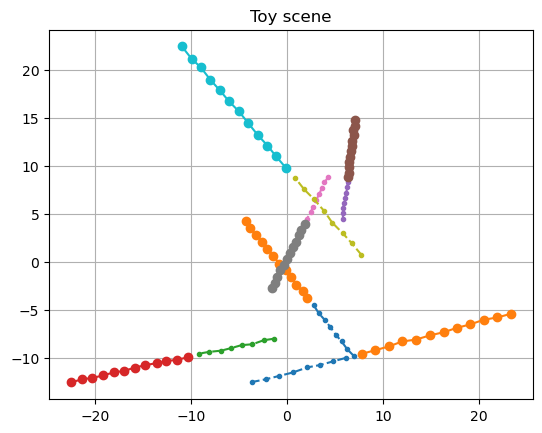

In [1]:
from utils.preprocessing import make_toy_batch
from visualize.plot import plot_scene

batch = make_toy_batch(num_scenes=1, agents_per_scene=6)
plot_scene(batch["past"][0], batch["future"][0])


In [2]:
from models.baselines import predict_cv
from evaluation.metrics import rmse, count_collisions

past, future = batch["past"][0], batch["future"][0]
pred = predict_cv(past, future.shape[1])

print("RMSE:", rmse(pred, future))
print("Collisions (pred):", count_collisions(pred))
print("Collisions (gt):", count_collisions(future))


RMSE: 0.5080116775112928
Collisions (pred): 1
Collisions (gt): 0


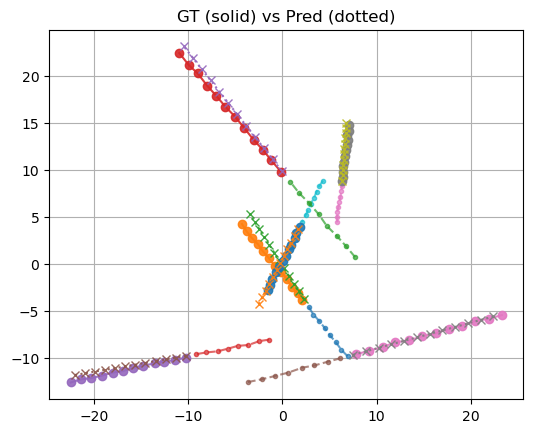

In [3]:
from visualize.plot import plot_scene
import matplotlib.pyplot as plt

def plot_pred_vs_gt(past, future, pred, title="GT (solid) vs Pred (dotted)"):
    plt.figure()
    A = past.shape[0]
    for a in range(A):
        # past
        plt.plot(past[a,:,0], past[a,:,1], "--", marker=".", alpha=0.7)
        # gt future
        plt.plot(future[a,:,0], future[a,:,1], "-", marker="o", alpha=0.9)
        # pred future
        plt.plot(pred[a,:,0],  pred[a,:,1],  ":", marker="x", alpha=0.9)
    plt.gca().set_aspect("equal"); plt.grid(True); plt.title(title)
    plt.show()

plot_pred_vs_gt(past, future, pred)


Collision steps (pred): [5]
Collision steps (gt):   []


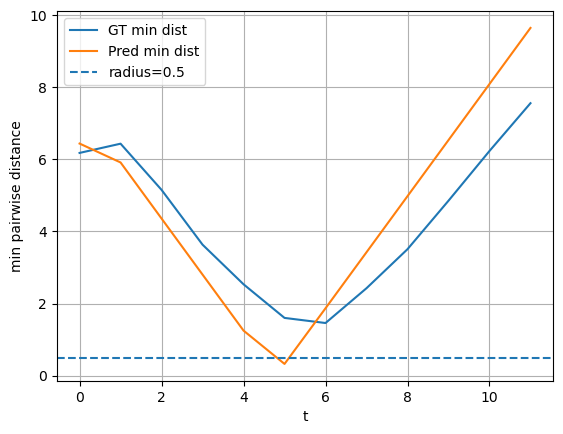

In [4]:
import numpy as np

def min_pairwise_distance_over_time(traj):
    # traj: (A, T, 2)
    A, T, _ = traj.shape
    mins = []
    for t in range(T):
        d = np.linalg.norm(traj[:,None,t,:] - traj[None,:,t,:], axis=-1)
        d = d + np.eye(A)*1e9  # ignore self
        mins.append(d.min())
    return np.array(mins)

def collision_timesteps(traj, radius=0.5):
    A, T, _ = traj.shape
    ts = []
    for t in range(T):
        d = np.linalg.norm(traj[:,None,t,:] - traj[None,:,t,:], axis=-1)
        close = (d < radius) & (~np.eye(A, dtype=bool))
        if np.any(close):
            ts.append(t)
    return ts

mins_pred = min_pairwise_distance_over_time(pred)
mins_gt   = min_pairwise_distance_over_time(future)

print("Collision steps (pred):", collision_timesteps(pred, radius=0.5))
print("Collision steps (gt):  ", collision_timesteps(future, radius=0.5))

plt.figure()
plt.plot(mins_gt, label="GT min dist")
plt.plot(mins_pred, label="Pred min dist")
plt.axhline(0.5, linestyle="--", label="radius=0.5")
plt.xlabel("t"); plt.ylabel("min pairwise distance"); plt.legend(); plt.grid(True); plt.show()



In [5]:
from utils.preprocessing import make_toy_batch
from models.baselines import predict_cv
from evaluation.metrics import rmse, count_collisions

def eval_cv_on_toy(num_scenes=10, A=6, T_p=8, T_f=12, seed=0):
    batch = make_toy_batch(num_scenes, A, T_p, T_f, seed)
    rmses, col_pred, col_gt = [], [], []
    for s in range(num_scenes):
        past, future = batch["past"][s], batch["future"][s]
        pred = predict_cv(past, future.shape[1])
        rmses.append(rmse(pred, future))
        col_pred.append(count_collisions(pred))
        col_gt.append(count_collisions(future))
    return {
        "rmse_mean": float(np.mean(rmses)),
        "rmse_std": float(np.std(rmses)),
        "collisions_pred_total": int(np.sum(col_pred)),
        "collisions_gt_total": int(np.sum(col_gt)),
    }

eval_cv_on_toy(num_scenes=20)



{'rmse_mean': 0.53683671531365,
 'rmse_std': 0.12193070908733651,
 'collisions_pred_total': 2,
 'collisions_gt_total': 3}